# Import necessary libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
)
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

ModuleNotFoundError: No module named 'statsmodels'

### Read and sort the data as dataframe

In [ ]:
file_path = 'data/DS_case_Dataset.xlsx'
data = pd.read_excel(file_path)

# "Uke sekv" converts it to integer
data['Uke number']  = data['Uke sekv'].str.extract(r'(\d+)').astype(int)

# Sorting the DataFrame based on the "Uke number" 
sorted_data = data.sort_values(by='Uke number')
sorted_data.drop(columns=['Uke number'], inplace=True)

# Time Series Analysis

### Map week numbers to date range

In [36]:
def week_to_date_range(week_number, starting_year):
    start_date = pd.to_datetime(f'{starting_year}-01-01') + pd.DateOffset(weeks=week_number - 1)
    end_date = start_date + pd.DateOffset(days=6)
    return start_date, end_date

sorted_data['Week'] = sorted_data['Uke sekv'].str.extract(r'Uke (\d+)').astype(int)
starting_year = 2022
sorted_data['Date Range'] = sorted_data['Week'].apply(lambda x: week_to_date_range(x, starting_year))
sorted_data[['Start Date', 'End Date']] = pd.DataFrame(sorted_data['Date Range'].tolist(), index=sorted_data.index)
sorted_data.drop(columns=['Week', 'Date Range'], inplace=True)
sorted_data.set_index('Start Date', inplace=True)

In [33]:
sorted_data

,Uke sekv,Produkt,Kundetype,Salg Kg norm,Kampanje ID,Insta,X,FaceBook
940,1,1,2,0.943371,2,0.461886,0.935067,0.890508
938,1,2,1,1.119004,2,0.461886,0.935067,0.890508
939,1,0,0,0.944060,2,0.461886,0.935067,0.890508
941,1,1,0,1.086230,2,0.461886,0.935067,0.890508
942,1,2,2,1.188191,2,0.461886,0.935067,0.890508
...,...,...,...,...,...,...,...,...
389,81,2,4,1.090781,6,0.908183,1.387445,1.698178
390,81,1,1,0.771270,6,0.908183,1.387445,1.698178
391,81,1,3,1.044953,6,0.908183,1.387445,1.698178
378,81,2,1,0.570898,6,0.908183,1.387445,1.698178


### Sales series forecasting using ARIMA

C:\Users\47939\PycharmProjects\Elliptic\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
C:\Users\47939\PycharmProjects\Elliptic\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
C:\Users\47939\PycharmProjects\Elliptic\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
C:\Users\47939\PycharmProjects\Elliptic\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


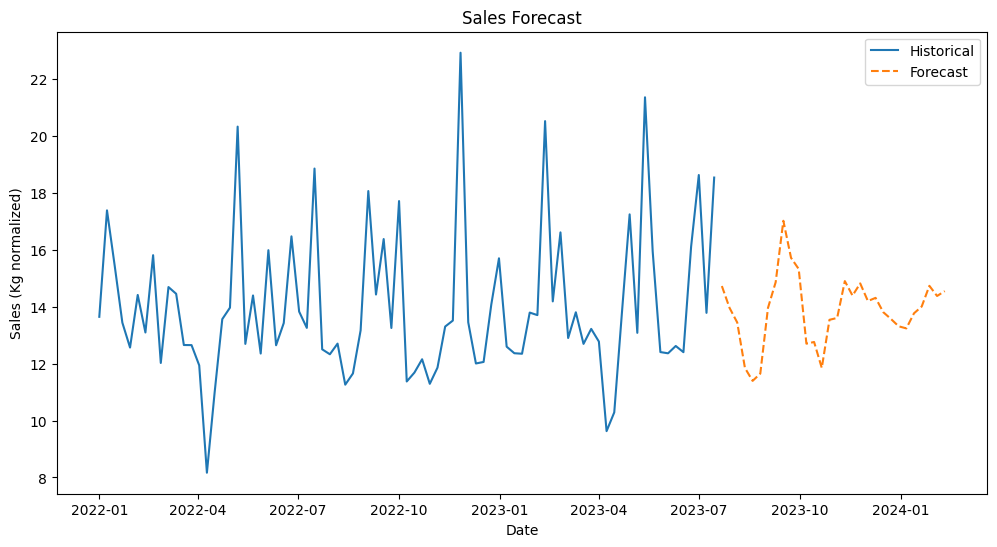

In [37]:
# Aggregate sales data by Date
sales_data = sorted_data.groupby(sorted_data.index)['Salg Kg norm'].sum()

# Define the model
model = ARIMA(sales_data, order=(9,1,5))  
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=30) 

plt.figure(figsize=(12, 6))
plt.plot(sales_data.index, sales_data, label='Historical')
plt.plot(forecast.index, forecast, label='Forecast', linestyle='--')
plt.legend()
plt.title('Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales (Kg normalized)')
plt.show()

# Feature Importance (Effect of advertisments)

### Convert fetures to numerical values

In [24]:
# Define mapping dictionaries
produkt_mapping = {'Melk A': 0, 'Melk B': 1, 'Melk C': 2}
kundetype_mapping = {'Annet': 0, 'Kundetype 1': 1, 'Kundetype 2': 2, 'Kundetype 3': 3, 'Kundetype 4': 4}
kampanje_mapping = {'1_1': 0, '1_2': 1, '1_4': 2,
                    '2_2': 3, '2_4': 4,
                    '3_2': 5, '3_3': 6, '3_4': 7}

sorted_data['Produkt'] = sorted_data['Produkt'].replace(produkt_mapping)
sorted_data['Kundetype'] = sorted_data['Kundetype'].replace(kundetype_mapping)
sorted_data['Kampanje ID'] = sorted_data['Kampanje ID'].replace(kampanje_mapping)
sorted_data['Uke sekv'] = sorted_data['Uke sekv'].str.extract('(\d+)').astype(int)

### Feature importance process

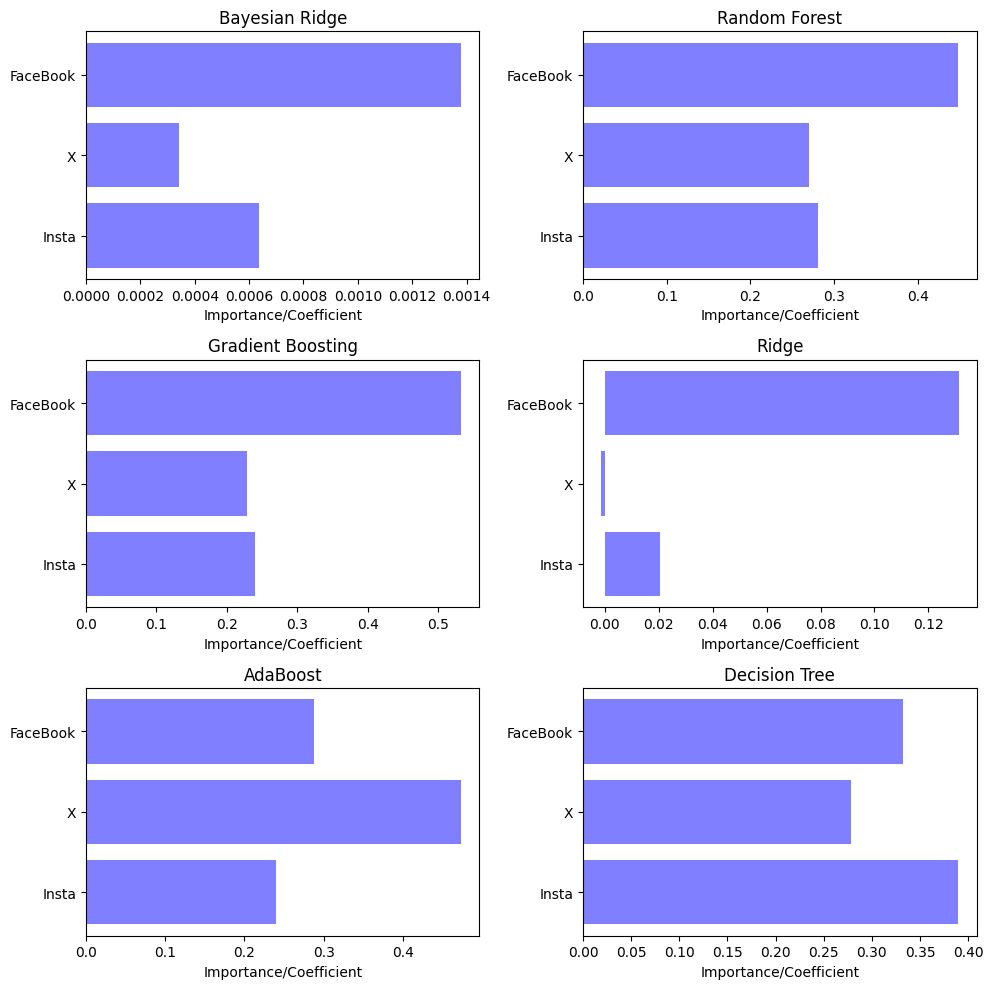

In [25]:
X = sorted_data[['Insta', 'X', 'FaceBook']]
y = sorted_data['Salg Kg norm']


models = {
    'Bayesian Ridge': BayesianRidge().fit(X, y),
    'Random Forest': RandomForestRegressor().fit(X, y),
    'Gradient Boosting': GradientBoostingRegressor().fit(X, y),
    'Ridge': Ridge().fit(X, y),
    'AdaBoost': AdaBoostRegressor().fit(X, y),
    'Decision Tree': DecisionTreeRegressor().fit(X, y)
}



fig, axs = plt.subplots(3, 2, figsize=(10, 10))

for i, (model_name, model) in enumerate(models.items()):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = model.coef_
    else:
        continue
    
    sorted_importances = importances
    sorted_labels = X.columns
    row = i // 2
    col = i % 2

    # Plot
    axs[row, col].barh(sorted_labels, sorted_importances, color='b', alpha=0.5)
    axs[row, col].set_title(model_name)
    axs[row, col].set_xlabel('Importance/Coefficient')
    #axs[row, col].set_ylabel('Features')

for i in range(len(models), 3 * 2):
    row = i // 2
    col = i % 2
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

# Correlation Heatmap of Campaigns based on Sales in Kg, across Kundetype


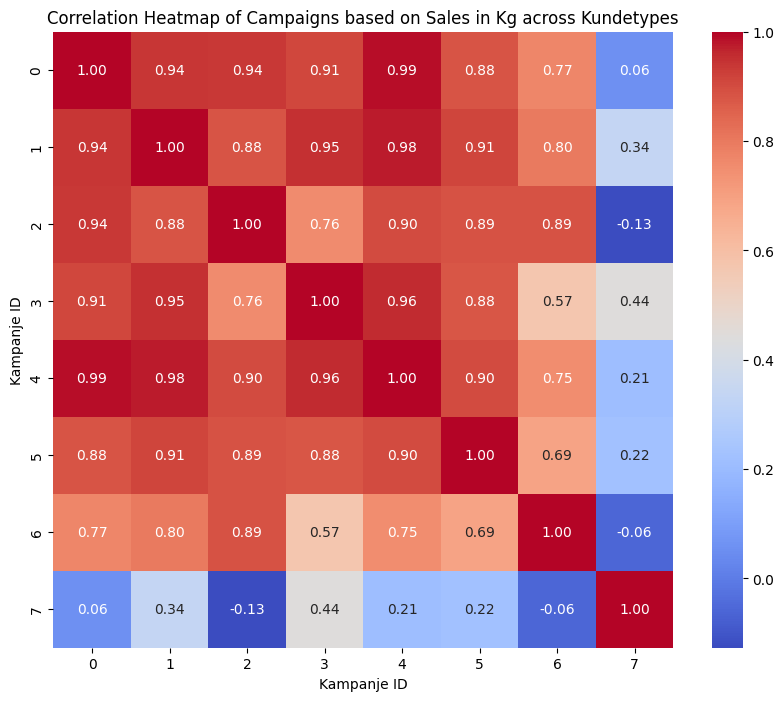

In [26]:
import seaborn as sns
# Pivot the data to have campaigns as columns, Kundetype as rows, with sales in kg
pivot_data = sorted_data.pivot_table(index='Kundetype', columns='Kampanje ID', values='Salg Kg norm', aggfunc='sum')

# correlation matrix
correlation_matrix = pivot_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Campaigns based on Sales in Kg across Kundetypes')
plt.show()

# Seasonal analysis of Sales with Kundetype

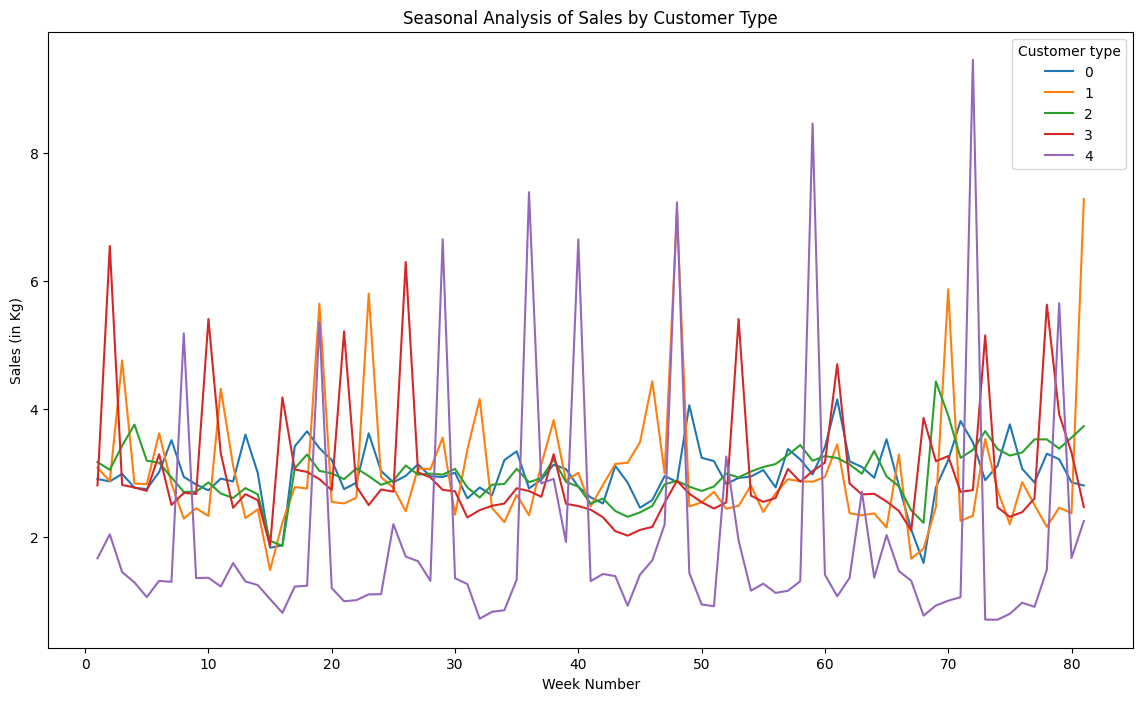

In [27]:
#Aggregate sales for each customer type for each week
aggregated_sales_customer = sorted_data.groupby(['Uke sekv', 'Kundetype'])['Salg Kg norm'].sum().reset_index()

pivot_sales_customer = aggregated_sales_customer.pivot(index='Uke sekv', columns='Kundetype', values='Salg Kg norm')

# Plot the seasonal analysis for each customer
plt.figure(figsize=(14, 8))
for column in pivot_sales_customer.columns:
    plt.plot(pivot_sales_customer.index, pivot_sales_customer[column], label=column)

plt.title('Seasonal Analysis of Sales by Customer Type')
plt.xlabel('Week Number')
plt.ylabel('Sales (in Kg)')
plt.legend(title='Customer type')
plt.show()

# Seasonal analysis of Sales with produkt

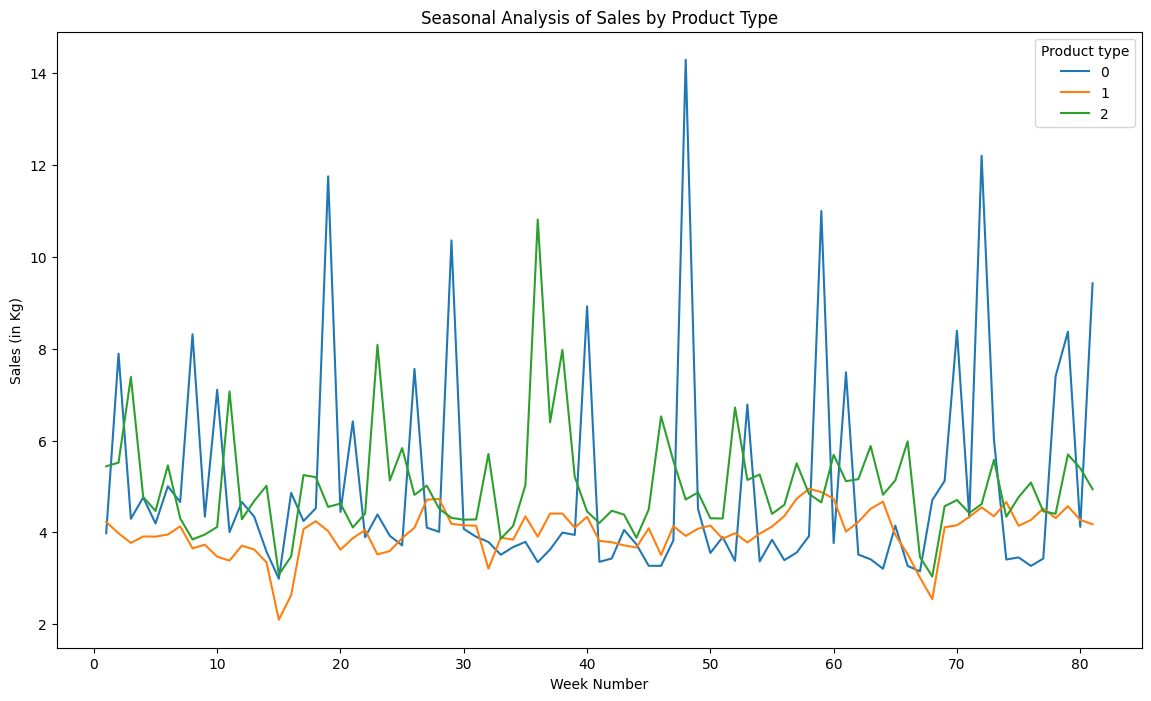

In [28]:
aggregated_sales = sorted_data.groupby(['Uke sekv', 'Produkt'])['Salg Kg norm'].sum().reset_index()

pivot_sales = aggregated_sales.pivot(index='Uke sekv', columns='Produkt', values='Salg Kg norm')

plt.figure(figsize=(14, 8))
for column in pivot_sales.columns:
    plt.plot(pivot_sales.index, pivot_sales[column], label=column)

plt.title('Seasonal Analysis of Sales by Product Type')
plt.xlabel('Week Number')
plt.ylabel('Sales (in Kg)')
plt.legend(title='Product type')
plt.show()

# Seasonal analysis of weekly sales data

Kampanje ID
3    442.098623
4    280.154920
2    115.570348
0     70.846731
5     67.603323
6     67.087773
7     63.652791
1     26.985507
Name: Salg Kg norm, dtype: float64


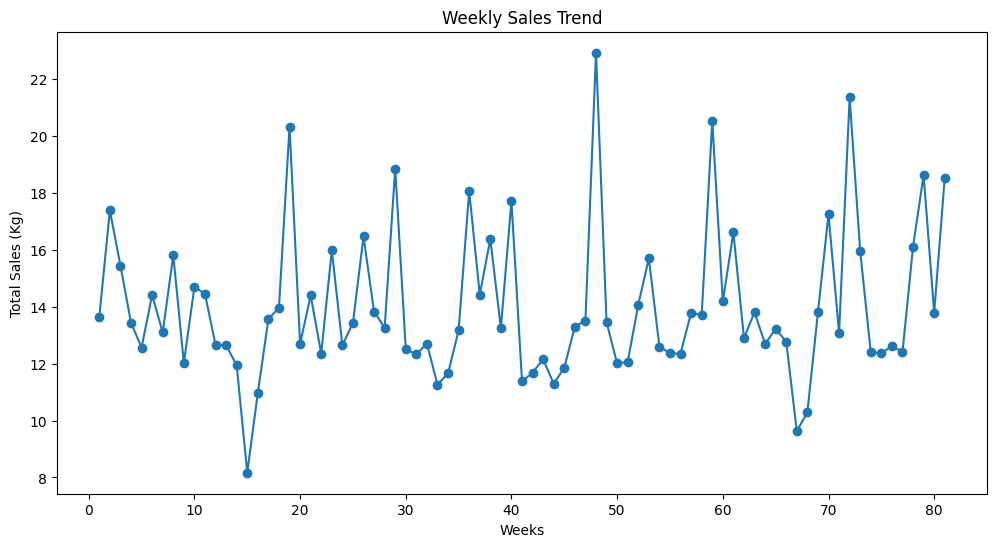

In [29]:
total_sales_by_kampanje = sorted_data.groupby('Kampanje ID')['Salg Kg norm'].sum().sort_values(ascending=False)

weekly_sales_trend = sorted_data.groupby('Uke sekv')['Salg Kg norm'].sum()
print(total_sales_by_kampanje)

plt.figure(figsize=(12, 6))
weekly_sales_trend.plot(kind='line', marker='o')
plt.title('Weekly Sales Trend')
plt.xlabel('Weeks')
plt.ylabel('Total Sales (Kg)')
plt.show()

# Correlation between platform KPIs and sales

In [30]:
platform_correlations = sorted_data[['Salg Kg norm', 'Insta', 'X', 'FaceBook']].corr()['Salg Kg norm'].drop('Salg Kg norm')

most_effective_platforms = platform_correlations.nlargest(2)
least_effective_platform = platform_correlations.idxmin()

print("Correlation between platform KPIs and sales:")
print(platform_correlations)

print("\nMost effective platforms based on correlation with sales:")
print(most_effective_platforms)

print("\nLeast effective platform based on correlation with sales:")
print(f"{least_effective_platform}: {platform_correlations[least_effective_platform]}")

Correlation between platform KPIs and sales:
Insta       0.012876
X           0.008255
FaceBook    0.052099
Name: Salg Kg norm, dtype: float64

Most effective platforms based on correlation with sales:
FaceBook    0.052099
Insta       0.012876
Name: Salg Kg norm, dtype: float64

Least effective platform based on correlation with sales:
X: 0.008254599845514658


# Polynomial regression analysis of Media on Kundetype

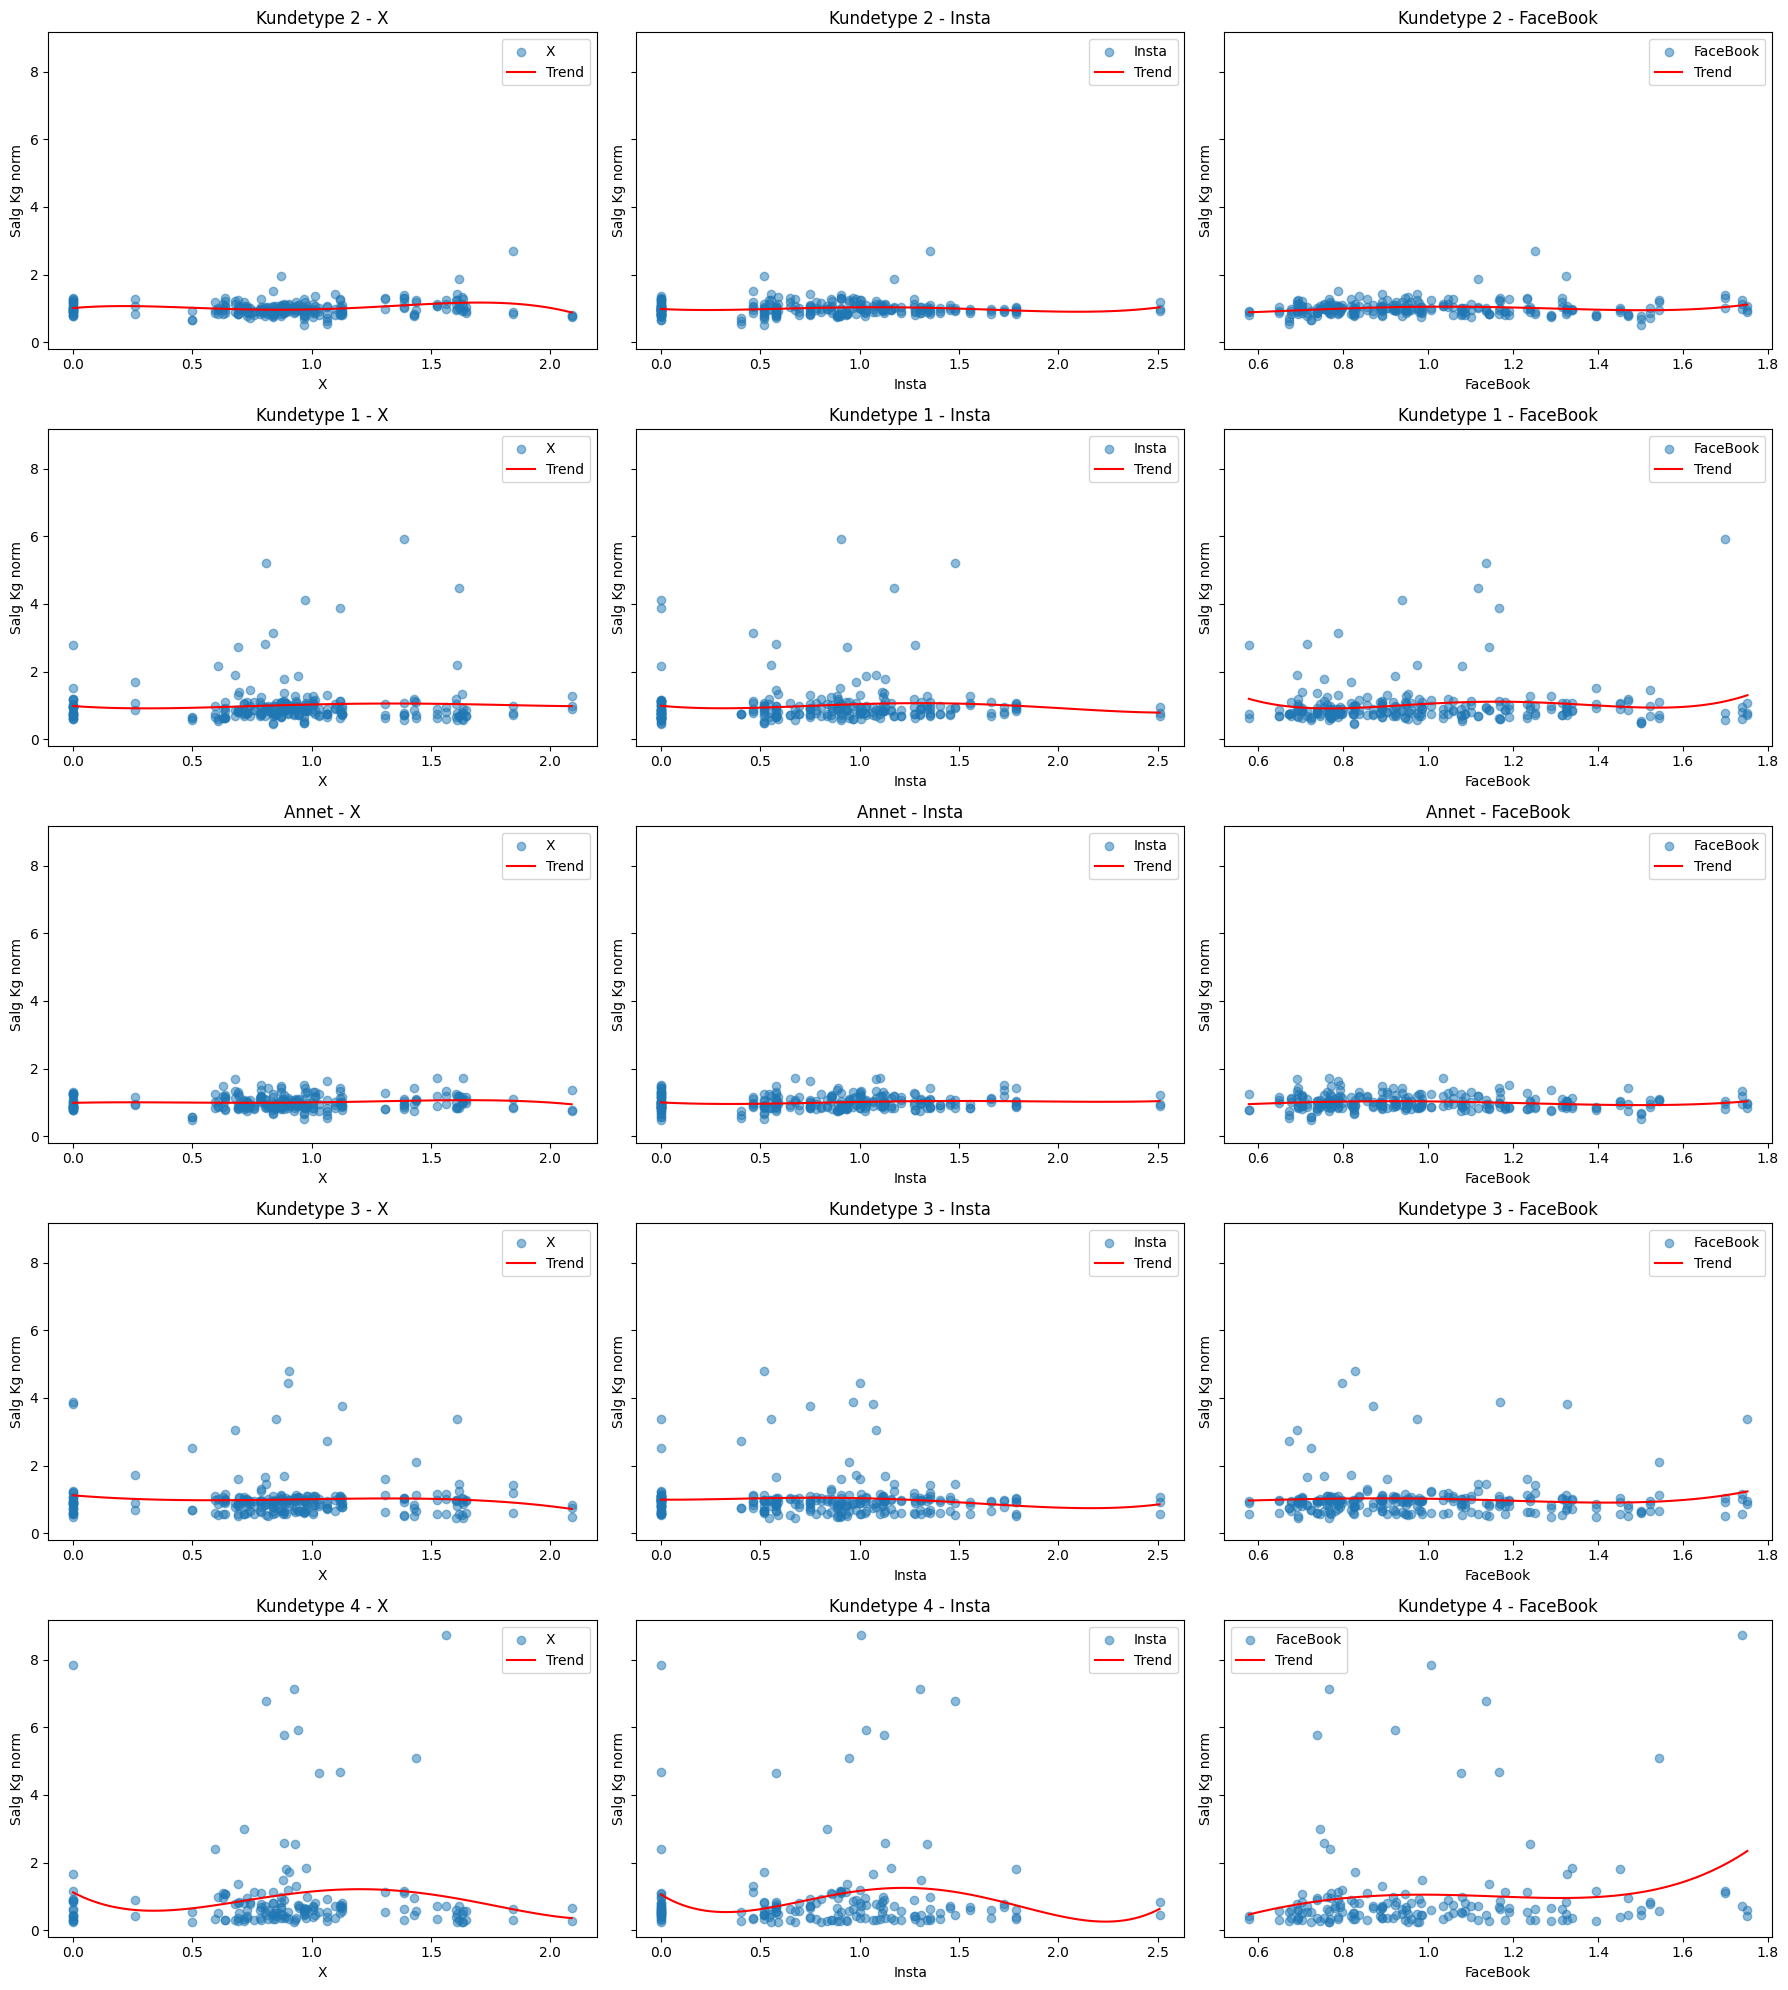

In [38]:
unique_kundetypes = sorted_data['Kundetype'].unique()[:5] 
social_media_metrics = ['X', 'Insta', 'FaceBook']

fig, axs = plt.subplots(5, 3, figsize=(18, 20), sharey=True)

for i, kundetype in enumerate(unique_kundetypes):
    for j, metric in enumerate(social_media_metrics):
        ax = axs[i, j]
        kundetype_data = sorted_data[sorted_data['Kundetype'] == kundetype].dropna()
        ax.scatter(kundetype_data[metric], kundetype_data['Salg Kg norm'], alpha=0.5, label=f'{metric}')

        # Polynomial Regression for a curvy trend
        z = np.polyfit(kundetype_data[metric], kundetype_data['Salg Kg norm'], 4)
        p = np.poly1d(z)
        
        # Creating smooth points for the poly line
        xp = np.linspace(kundetype_data[metric].min(), kundetype_data[metric].max(), 100)
        ax.plot(xp, p(xp), 'r-', label='Trend')

        ax.set_title(f'{kundetype} - {metric}')
        ax.set_xlabel(metric)
        ax.set_ylabel('Salg Kg norm')
        ax.legend()

plt.tight_layout()
plt.show()